In [26]:
import torch
import torch.nn as nn
import scipy
import numpy as np
import matplotlib.pyplot as plt

In [27]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        
        activation = nn.Tanh
        
        self.lambda_1 = nn.Sequential(*[
                        nn.Linear(1, 1,bias=False),
                        nn.ReLU()])
        
        self.lambda_2 = nn.Sequential(*[
                        nn.Linear(1, 1,bias=False),
                        nn.ReLU()])
    
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN+2, N_HIDDEN+2),
                            activation()]) for _ in range(N_LAYERS-1)])
        
    
           
        self.aggregate = nn.Linear(N_HIDDEN+2,10)
        self.fce = nn.Linear(N_HIDDEN+2, N_OUTPUT) 
    def forward(self, x):#,y,t):
        
        x = self.fcs(x)
        l1 = self.lambda_1(torch.Tensor([1]))
        l2 = self.lambda_1(torch.Tensor([1]))

        x = torch.cat((x,torch.ones(len(x),1)*l1,torch.ones(len(x),1)*l2), dim=1)

        x = self.fch(x)
        
        x = self.fce(x)
        
        return x


In [28]:

data = scipy.io.loadmat('')#path to data file

U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

# Rearrange Data 
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x_e = XX.flatten()[:,None] # NT x 1
y_e = YY.flatten()[:,None] # NT x 1
t_e = TT.flatten()[:,None] # NT x 1

u_e = UU.flatten()[:,None] # NT x 1
v_e = VV.flatten()[:,None] # NT x 1
p_e = PP.flatten()[:,None] # NT x 1

In [ ]:
model = FCN(3,2,10,5)
model.load_state_dict(torch.load(''),strict=False) #path to model file 

In [30]:
x_w = torch.Tensor(x_e).view(-1,1)
y_w = torch.Tensor(y_e).view(-1,1)
t_w = torch.Tensor(t_e).view(-1,1)
p   = torch.Tensor(p_e).view(-1,1)


with torch.no_grad():
    
    p_psi = model(torch.cat([x_w,y_w,t_w],1))
    p_pre = p_psi[:,0]
    psi_pre = p_psi[:,1]
    

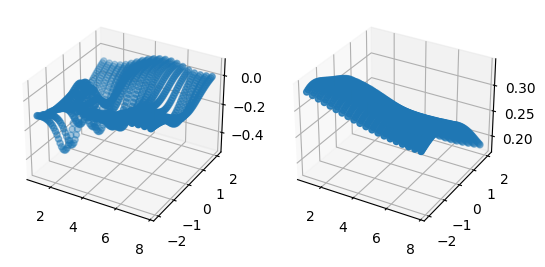

In [31]:
import plotly.graph_objs as go
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

p_train = torch.Tensor(p_e).view(-1,1)
fig = plt.figure()

ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(x_w.view(1,-1).numpy()[0].tolist()[::1000], y_w.view(1,-1).numpy()[0].tolist()[::1000], p_train.view(1,-1).numpy()[0].tolist()[::1000])

ax_1 = fig.add_subplot(1,2,2, projection='3d')
ax_1.scatter(x_w.view(1,-1).numpy()[0].tolist()[::1000], y_w.view(1,-1).numpy()[0].tolist()[::1000], p_pre.view(1,-1).numpy()[0].tolist()[::1000])

plt.show()

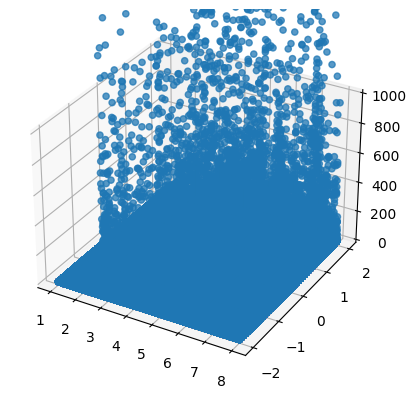

In [13]:
import plotly.graph_objs as go
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

p_train = torch.Tensor(p_e).view(-1,1)
fig = plt.figure()

ax = fig.add_subplot(1,1,1, projection='3d')

diff = np.array((np.abs((p_train.view(1,-1).numpy()[0]-p_pre.view(1,-1).numpy()[0])/p_train.view(1,-1).numpy()[0])).tolist())
diff_1 = diff[diff<100]
ax.scatter(x_w.view(1,-1).numpy()[0].tolist(), y_w.view(1,-1).numpy()[0].tolist(),diff )
ax.set_zlim(0,1000)


plt.show()